<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#基于Cora数据集的GCN节点分类" data-toc-modified-id="基于Cora数据集的GCN节点分类-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1 Classification of GCN nodes based on Citeseer dataset</a></span><ul class="toc-item"><li><span><a href="#SetUp" data-toc-modified-id="SetUp-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SetUp</a></span></li><li><span><a href="#数据准备" data-toc-modified-id="数据准备-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>data preparation</a></span></li><li><span><a href="#图卷积层定义" data-toc-modified-id="图卷积层定义-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Graph convolution layer definition
</a></span></li><li><span><a href="#模型定义" data-toc-modified-id="模型定义-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Model definition
</a></span></li><li><span><a href="#模型训练" data-toc-modified-id="模型训练-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Model training
</a></span></li></ul></li></ul></div>

# GCN node classification based on Citeseer dataset

> Indented block



<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/FighterLYL/GraphNeuralNetwork/blob/master/chapter5/GCN_Cora.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

When running in Colab, you can choose to use `GPU` through `Code Execution Program -> Change Runtime Type`

## SetUp

In [ ]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

## data preparation

In [ ]:
Data = namedtuple('Data', ['x', 'y', 'adjacency',
                           'train_mask', 'val_mask', 'test_mask'])

In [ ]:
Data = namedtuple('Data', ['x', 'y', 'adjacency',
                           'train_mask', 'val_mask', 'test_mask'])


def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)


class CiteseerData(object):
    download_url = "https://raw.githubusercontent.com/kimiyoung/planetoid/master/data"
    filenames = ["ind.citeseer.{}".format(name) for name in
                 ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']]

    def __init__(self, data_root="citeseer", rebuild=False):

        self.data_root = data_root
        save_file = osp.join(self.data_root, "processed_citeseer.pkl")
        if osp.exists(save_file) and not rebuild:
            print("Using Cached file: {}".format(save_file))
            self._data = pickle.load(open(save_file, "rb"))
        else:
            self.maybe_download()
            self._data = self.process_data()
            with open(save_file, "wb") as f:
                pickle.dump(self.data, f)
            print("Cached file: {}".format(save_file))
    
    @property
    def data(self):
        """Return Data data objects, including x, y, adjacency, train_mask, val_mask, test_mask"""
        return self._data

    def process_data(self):
        """
        Process data to get node features and labels, adjacency matrix, training set, validation set and test set
        Quoted from：https://github.com/rusty1s/pytorch_geometric
        """
        print("Process data ...")
        _, tx, allx, y, ty, ally, graph, test_index = [self.read_data(
            osp.join(self.data_root, "raw", name)) for name in self.filenames]
        train_index = np.arange(y.shape[0])
        val_index = np.arange(y.shape[0], y.shape[0] + 500)
        sorted_test_index = sorted(test_index)

        x = np.concatenate((allx, tx), axis=0)
        y = np.concatenate((ally, ty), axis=0).argmax(axis=1)

        x[test_index] = x[sorted_test_index]
        y[test_index] = y[sorted_test_index]
        num_nodes = x.shape[0]

        train_mask = np.zeros(num_nodes, dtype=np.bool)
        val_mask = np.zeros(num_nodes, dtype=np.bool)
        test_mask = np.zeros(num_nodes, dtype=np.bool)
        train_mask[train_index] = True
        val_mask[val_index] = True
        test_mask[test_index] = True
        adjacency = self.build_adjacency(graph)
        print("Node's feature shape: ", x.shape)
        print("Node's label shape: ", y.shape)
        print("Adjacency's shape: ", adjacency.shape)
        print("Number of training nodes: ", train_mask.sum())
        print("Number of validation nodes: ", val_mask.sum())
        print("Number of test nodes: ", test_mask.sum())

        return Data(x=x, y=y, adjacency=adjacency,
                    train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

    def maybe_download(self):
        save_path = os.path.join(self.data_root, "raw")
        for name in self.filenames:
            if not osp.exists(osp.join(save_path, name)):
                self.download_data(
                    "{}/{}".format(self.download_url, name), save_path)

    @staticmethod
    def build_adjacency(adj_dict):
        """Create adjacency matrix from adjacency list"""
        edge_index = []
        num_nodes = len(adj_dict)
        for src, dst in adj_dict.items():
            edge_index.extend([src, v] for v in dst)
            edge_index.extend([v, src] for v in dst)
        # Remove duplicate edges
        edge_index = list(k for k, _ in itertools.groupby(sorted(edge_index)))
        edge_index = np.asarray(edge_index)
        adjacency = sp.coo_matrix((np.ones(len(edge_index)), 
                                   (edge_index[:, 0], edge_index[:, 1])),
                    shape=(num_nodes, num_nodes), dtype="float32")
        return adjacency

    @staticmethod
    def read_data(path):
        """Use different methods to read raw data for further processing"""
        name = osp.basename(path)
        if name == "ind.citeseer.test.index":
            out = np.genfromtxt(path, dtype="int64")
            return out
        else:
            out = pickle.load(open(path, "rb"), encoding="latin1")
            out = out.toarray() if hasattr(out, "toarray") else out
            return out

    @staticmethod
    def download_data(url, save_path):
        """Data download tool, which will download when the original data does not exist"""
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        data = urllib.request.urlopen(url)
        filename = os.path.split(url)[-1]

        with open(os.path.join(save_path, filename), 'wb') as f:
            f.write(data.read())

        return True

    @staticmethod
    def normalization(adjacency):
        """Calculation L=D^-0.5 * (A+I) * D^-0.5"""
        adjacency += sp.eye(adjacency.shape[0])    # Increase self-connection
        degree = np.array(adjacency.sum(1))
        d_hat = sp.diags(np.power(degree, -0.5).flatten())
        return d_hat.dot(adjacency).dot(d_hat).tocoo()

dataset = CiteseerData().data

Process data ...


IndexError: ignored

## Graph convolution layer definition

In [ ]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """Graph convolution：L*X*\theta

        Args:
        ----------
            input_dim: int
                Dimension of node input feature
            output_dim: int
                Output feature dimension
            use_bias : bool, optional
                Whether to use offset
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        """The adjacency matrix is a sparse matrix, so sparse matrix multiplication is used in the calculation
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                Adjacency matrix
            input_feature: torch.Tensor
                Input characteristics
        """
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')'


## Model definition

Readers can modify and experiment the GCN model structure by themselves

In [ ]:
class GcnNet(nn.Module):
    """
    Define a model with two layers of GraphConvolution
    """
    def __init__(self, input_dim=1433):
        super(GcnNet, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 16)
        self.gcn2 = GraphConvolution(16, 7)
    
    def forward(self, adjacency, feature):
        h = F.relu(self.gcn1(adjacency, feature))
        logits = self.gcn2(adjacency, h)
        return logits


## Model training

In [ ]:
# Hyperparameter definition
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 200
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Load data and convert to torch.Tensor
dataset = CiteseerData().data
node_feature = dataset.x / dataset.x.sum(1, keepdims=True)  # Normalize the data so that each row is 1
tensor_x = tensor_from_numpy(node_feature, DEVICE)
tensor_y = tensor_from_numpy(dataset.y, DEVICE)
tensor_train_mask = tensor_from_numpy(dataset.train_mask, DEVICE)
tensor_val_mask = tensor_from_numpy(dataset.val_mask, DEVICE)
tensor_test_mask = tensor_from_numpy(dataset.test_mask, DEVICE)
normalize_adjacency = CiteseerData.normalization(dataset.adjacency)   # Normalized adjacency matrix

num_nodes, input_dim = node_feature.shape
indices = torch.from_numpy(np.asarray([normalize_adjacency.row, 
                                       normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values, 
                                            (num_nodes, num_nodes)).to(DEVICE)

Process data ...


IndexError: ignored

In [ ]:
# Model definition: Model, Loss, Optimizer
model = GcnNet(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)

In [ ]:
# Training body function
def train():
    loss_history = []
    val_acc_history = []
    model.train()
    train_y = tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        logits = model(tensor_adjacency, tensor_x)  # Forward propagation
        train_mask_logits = logits[tensor_train_mask]   # Only select training nodes for supervision
        loss = criterion(train_mask_logits, train_y)    # Calculate the loss value
        optimizer.zero_grad()
        loss.backward()     # Backpropagation calculation parameter gradient
        optimizer.step()    # Gradient update using optimization method
        train_acc, _, _ = test(tensor_train_mask)     # Calculate the accuracy on the current model training set
        val_acc, _, _ = test(tensor_val_mask)     # Calculate the accuracy of the current model on the validation set
        # Record the change of loss value and accuracy during training, used for drawing
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".format(
            epoch, loss.item(), train_acc.item(), val_acc.item()))
    
    return loss_history, val_acc_history


In [ ]:
# Test function
def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_adjacency, tensor_x)
        test_mask_logits = logits[mask]
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu().numpy()


In [ ]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()


In [ ]:
loss, val_acc = train()
test_acc, test_logits, test_label = test(tensor_test_mask)
print("Test accuarcy: ", test_acc.item())

Epoch 000: Loss 1.9418, TrainAcc 0.3333, ValAcc 0.1960
Epoch 001: Loss 1.5670, TrainAcc 0.3333, ValAcc 0.1960
Epoch 002: Loss 1.2874, TrainAcc 0.3667, ValAcc 0.2040
Epoch 003: Loss 1.1071, TrainAcc 0.75, ValAcc 0.5780
Epoch 004: Loss 1.0043, TrainAcc 0.8167, ValAcc 0.6640
Epoch 005: Loss 0.9323, TrainAcc 0.9, ValAcc 0.7280
Epoch 006: Loss 0.8574, TrainAcc 0.9167, ValAcc 0.6980
Epoch 007: Loss 0.7906, TrainAcc 0.9167, ValAcc 0.7000
Epoch 008: Loss 0.7278, TrainAcc 0.9333, ValAcc 0.7280
Epoch 009: Loss 0.6589, TrainAcc 0.9333, ValAcc 0.7500
Epoch 010: Loss 0.5902, TrainAcc 0.95, ValAcc 0.7780
Epoch 011: Loss 0.5261, TrainAcc 0.95, ValAcc 0.7860
Epoch 012: Loss 0.4638, TrainAcc 0.95, ValAcc 0.7700
Epoch 013: Loss 0.4055, TrainAcc 0.95, ValAcc 0.7620
Epoch 014: Loss 0.3559, TrainAcc 0.9667, ValAcc 0.7780
Epoch 015: Loss 0.3106, TrainAcc 0.9667, ValAcc 0.7800
Epoch 016: Loss 0.2721, TrainAcc 0.9667, ValAcc 0.7940
Epoch 017: Loss 0.2394, TrainAcc 0.9833, ValAcc 0.8020
Epoch 018: Loss 0.2127,

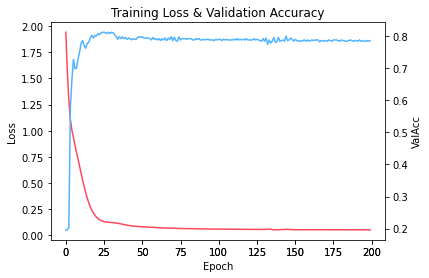

In [ ]:
plot_loss_with_acc(loss, val_acc)

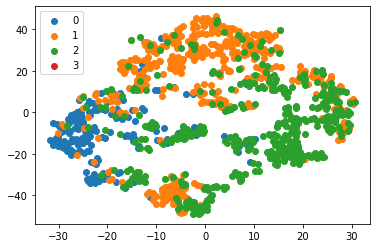

In [ ]:
# Draw TSNE dimension reduction graph of test data
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()